# ART MOVEMENT CLASSIFIER

Four art movements: Impressionism, Post-Impressionism, Expressionism and Realism.

Art movement = Style in our descriptions

## Data processing

In this section we organize the data into folders and prepare training and testing datasets. We also vizualize the paintings from different styles.

In [1]:
#!pip install wandb

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import zipfile
import glob
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random


from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch
from torchvision import datasets,models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch import nn
import torch.nn.functional as F
import wandb


np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')



In [220]:
wandb.init(project='mldlproject', save_code=True, config={
            "epochs": 15,
            "batch_size": 32,
            "lr": 2e-3,
            "dropout": 0,
            "imagedim":(224,224),
            "dataset":"v6","transforms":"v1",
            "model_name":"resnet","optimizer":"SGD","momentum":0.5, "lrscheduler":True, "gradient_clipping":False, "retrained": True,"weighted_loss":True})  # mode='disabled',
config = wandb.config

In [221]:
# 0 = colab, 1 = kaggle
cloud = 1

if cloud == 0:
  basepath = './drive/MyDrive/mldlproject'
elif cloud == 1:
  basepath = '/kaggle/input/datasetv3art'
else:
  basepath = '.'

In [222]:

if(not os.path.isdir(basepath + '/dataset'+ config.dataset)):
  with zipfile.ZipFile(basepath +'/dataset' + config.dataset +'.zip') as ds_zip:
      ds_zip.extractall('')

if config.dataset == "v6":
  trainfolder = "/train_p/"
  testfolder = "/test_p/"
else:
  trainfolder = "/train/"
  testfolder = "/test/"

,Unnamed: 0,filename,style,genre
0,46698,1.jpg,Expressionism,flower painting
1,53019,100.jpg,Post-Impressionism,landscape
2,50054,1000.jpg,Realism,landscape
3,70153,100001.jpg,Impressionism,nude painting (nu)
4,22840,100006.jpg,Impressionism,portrait


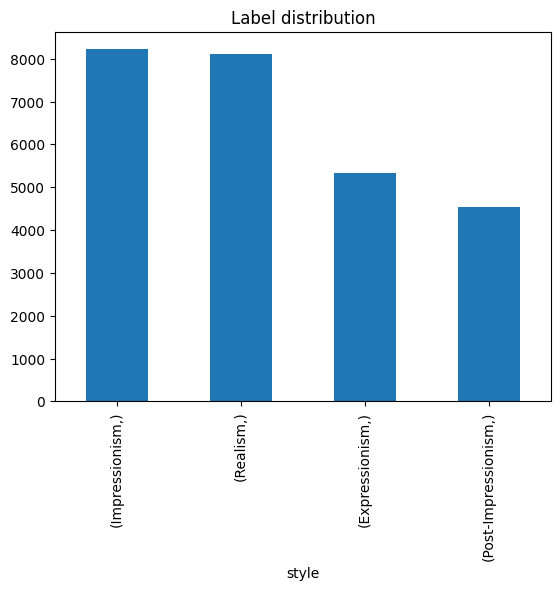

In [223]:
try:
    filtered_df = pd.read_csv(basepath + '/train_info_adj.csv')
except FileNotFoundError:
    df = pd.read_csv(basepath + '/train_info/train_info.csv')
    filtered_df = df[df['style'].isin(['Post-Impressionism','Impressionism', 'Realism', 'Expressionism'])]
    filtered_df = filtered_df[['filename','style','genre']]
    filtered_df = filtered_df.sort_values(by=['filename'])
    filtered_df.to_csv(basepath + '/train_info_adj.csv',index='false')

stylecounts = filtered_df[['style']].value_counts()


stylecounts.plot.bar(title="Label distribution")


filtered_df.head()

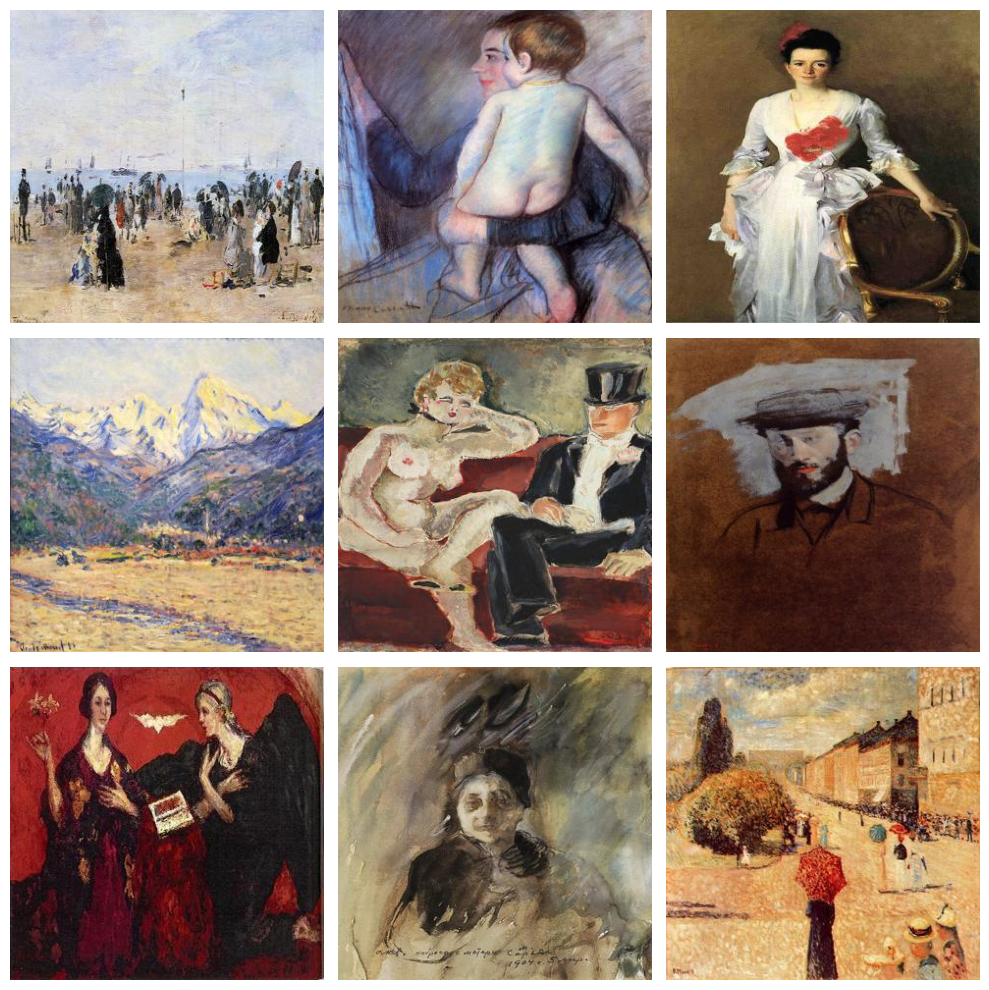

In [224]:
if(cloud == 1):
    basepath = basepath+ "/dataset" +config.dataset

def plot_random_images(allstyles=True,startchar=''):
  if not allstyles:
    image_files = [f for f in os.listdir(basepath + '/dataset'+config.dataset+trainfolder) if f.startswith(startchar)]
  else:
    image_files = os.listdir(basepath + '/dataset'+config.dataset+trainfolder)

  selected_images = random.sample(image_files, 9)

  rows = 3
  cols = 3
  fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

  # Plot each selected image
  for i, image_name in enumerate(selected_images):
      img_path = os.path.join(basepath + '/dataset'+config.dataset+trainfolder, image_name)
      img = mpimg.imread(img_path)
      ax = axes[i // cols, i % cols]
      ax.imshow(img)
      ax.axis('off')

  # Adjust layout
  plt.tight_layout()
  plt.show()

plot_random_images()

In [225]:
stylecounts_tensor = torch.tensor(stylecounts)
max_count = torch.max(stylecounts_tensor)

#loss_weights1 = torch.sum(stylecounts) / (stylecounts * 4)
#print(loss_weights1)


loss_weights = torch.round(1.5 - (stylecounts_tensor / max_count), decimals = 1)
# we sort the values according to the order in which we have the labels in the training/testing: Impressionism, Post-Impressionism, Expressionism, Realism
loss_weights = loss_weights[[0,3,2,1]]
# Set the Post-Impressionism to 1, because it is the most missclassified label
loss_weights[1] = 1
loss_weights

/tmp/ipykernel_34/3283535766.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stylecounts_tensor = torch.tensor(stylecounts)


tensor([0.5000, 1.0000, 0.9000, 0.5000])

We can see that there are considerable inbalances between the frequencies of each class. We could use weighted loss, data duplication with augmentation of the poorly represented classes or undersampling the most common classes.

**first version of the dataset**

In the first version we undersample the most common classes. We use stratified sampling - each class has the same proportion of each genre as in the whole dataset. Everything is balanced. Each label has the same number of artworks in both the test and training dataset, genres are sampled as they are distributed in each class.

**second version of the dataset**

In the second version we save the image labels in the image paths to retrieve the labels from the path and save time when loading the datasets. This way we do not search for the row in the dataframe everytime a new image is opened to retrieve the label from there. We expect better time efficiency.

**third version of the dataset**

Rescale all images to 320*320 on disk because we do not need images of huge sizes. We expect to further improve the loading times and decrease storage size.

**fourth version of the dataset**

Instead of using stratified sampling we split each of the initial 9 train folders into train and test. We have some inbalances between classes, but we have more data. We compare performance. We also use 2nd and 3rd version dataset optimizations.

In [226]:
int(config.imagedim[0]/8 * config.imagedim[1]/8 * 3)

2352

In [227]:
## split training and validation

train_list = os.listdir(basepath + '/dataset'+config.dataset+trainfolder)
test_list = os.listdir(basepath + '/dataset'+config.dataset+testfolder)
train_list,val_list = train_test_split(train_list, test_size=0.2, random_state=0)


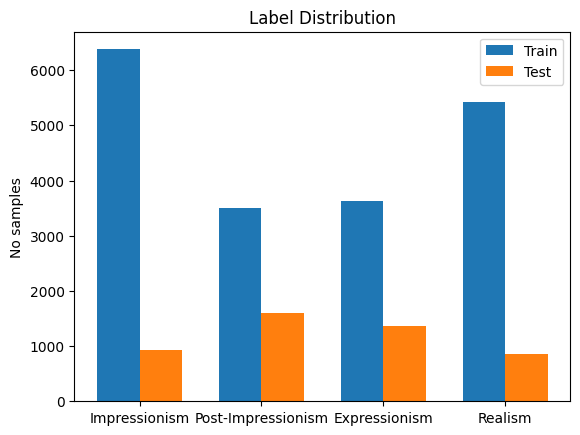

In [228]:
## Distribution in a dataset
distributions_train = {}
distributions_train['Impressionism'] = 0
distributions_train['Post-Impressionism'] = 0
distributions_train['Expressionism'] = 0
distributions_train['Realism'] = 0
for img in os.listdir(basepath +'/dataset'+config.dataset+trainfolder):
  if img.startswith('i'):
    distributions_train['Impressionism'] +=1
  elif img.startswith('p'):
    distributions_train['Post-Impressionism'] +=1
  elif img.startswith('e'):
    distributions_train['Expressionism'] +=1
  elif img.startswith('r'):
    distributions_train['Realism'] +=1

distributions_test = {}
distributions_test['Expressionism'] = 0
distributions_test['Impressionism'] = 0
distributions_test['Realism'] = 0
distributions_test['Post-Impressionism'] = 0
for img in os.listdir(basepath + '/dataset'+config.dataset+testfolder):
  if img.startswith('i'):
    distributions_test['Impressionism'] +=1
  elif img.startswith('p'):
    distributions_test['Post-Impressionism'] +=1
  elif img.startswith('e'):
    distributions_test['Expressionism'] +=1
  elif img.startswith('r'):
    distributions_test['Realism'] +=1

categories = list(distributions_train.keys())
values_train = list(distributions_train.values())
values_test = list(distributions_test.values())

fig, ax = plt.subplots()
bar_width = 0.35

ax.bar(categories, values_train, width=bar_width, label='Train')

ax.bar([i + bar_width for i in range(len(categories))], values_test, width=bar_width, label='Test')

ax.set_ylabel('No samples')
ax.set_title('Label Distribution')
ax.set_xticks([i + bar_width / 2 for i in range(len(categories))])
ax.set_xticklabels(categories)
ax.legend()

plt.show()



In [229]:
stylecounts = torch.tensor(values_train)
loss_weights = torch.sum(stylecounts) / (stylecounts * 4) #4 = num classes

#loss_weights = loss_weights[[0,3,2,1]]
print(loss_weights)

tensor([0.7420, 1.3502, 1.3048, 0.8732])


In [230]:
if(config.model_name == "inception"):
  resize_dim =  299
else:
  resize_dim = 224

if config.transforms == "v1":
  train_transforms = v2.Compose([
      v2.RandomApply(transforms= [v2.RandomRotation(degrees=(0, 180))],p=0.1),
      v2.RandomHorizontalFlip(p=0.1),
      v2.RandomVerticalFlip(p=0.1),
      v2.RandomApply(transforms=[v2.RandomCrop(size=config.imagedim)], p=0.2),
      v2.Resize((resize_dim,resize_dim)),
      v2.ToTensor(),

      v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

  test_transforms = v2.Compose([
      v2.Resize((resize_dim,resize_dim)),
      v2.ToTensor(),
      v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
elif config.transforms == "v2":
  if (config.dataset != "v5"): # Add croppings if not already in dataset
    train_transforms = v2.Compose([
        #v2.RandomSolarize(threshold=200.0),
        v2.RandomApply(transforms= [v2.RandomRotation(degrees=(0, 180))],p=0.1),
        v2.RandomHorizontalFlip(p=0.1),
        v2.RandomVerticalFlip(p=0.1),
        v2.ColorJitter(saturation=(0.9,1.5), contrast =(0.9,1.5),brightness=(.9,1.3)),
        v2.RandomApply(transforms=[v2.RandomCrop(size=config.imagedim)], p=0.2),

        v2.Resize((resize_dim,resize_dim)),
        v2.ToTensor(),

        v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
  else:
    train_transforms = v2.Compose([
        #v2.RandomSolarize(threshold=200.0),
        v2.RandomHorizontalFlip(p=0.1),
        v2.RandomVerticalFlip(p=0.1),
        # v2.ColorJitter(saturation=.2, contrast =.2, hue=.3),
        v2.ColorJitter(saturation=(0.9,1.5), contrast =(0.9,1.5),brightness=(.9,1.3)),

        v2.Resize((resize_dim,resize_dim)),
        v2.ToTensor(),

        v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

  test_transforms = v2.Compose([
      #v2.RandomSolarize(threshold=200.0),
      v2.ColorJitter(saturation=(0.9,1.5), contrast =(0.9,1.5),brightness=(.9,1.3)),
      #v2.RandomPosterize(bits=5),

      v2.Resize((resize_dim,resize_dim)),
      v2.ToTensor(),
      v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
else:
  additional_transforms = v2.Compose([
      # Add your transforms here
      v2.RandomHorizontalFlip(p=0.1),
      v2.RandomVerticalFlip(p=0.1),
      #v2.RandomSolarize(threshold=192.0),
      v2.ColorJitter(saturation=(0.9,1.5), contrast =(0.9,1.5),brightness=(.9,1.3)),

      v2.Resize((resize_dim,resize_dim)),
      v2.ToTensor(),

      v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      # Add more transforms if needed
  ])
  additional_transforms_t = v2.Compose([
      v2.ColorJitter(saturation=(0.9,1.5), contrast =(0.9,1.5),brightness=(.9,1.3)),
      #v2.RandomPosterize(bits=5),

      v2.Resize((resize_dim,resize_dim)),
      v2.ToTensor(),
      v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  train_transforms = v2.Compose([
      v2.FiveCrop(size=(resize_dim, resize_dim)),
       ])

  test_transforms = v2.Compose([
      v2.FiveCrop(size=(resize_dim, resize_dim)),
  ])

  #transforms v3 (testing with undersampled dataset v3)
demo_transforms = v2.Compose([
        #v2.RandomSolarize(threshold=200.0),
        v2.RandomHorizontalFlip(p=0.1),
        v2.RandomVerticalFlip(p=0.1),
        # v2.ColorJitter(saturation=.2, contrast =.2, hue=.3),
        v2.ColorJitter(saturation=(1.29,1.31), contrast =(1.29,1.31),brightness=(1.29,1.31)),

        v2.Resize((resize_dim,resize_dim)),
        #v2.ToTensor(),

        #v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


['i_92358.jpg', 'i_47160.jpg', 'r_65759.jpg', 'i_71921.jpg']


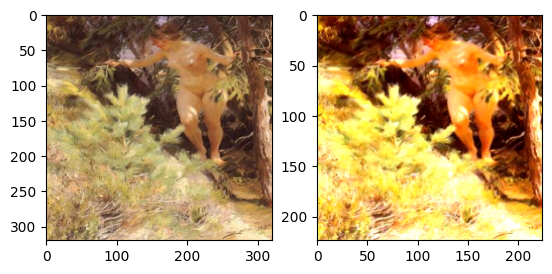

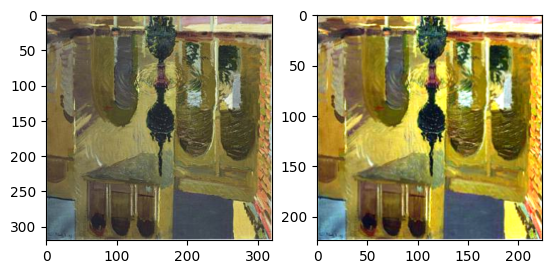

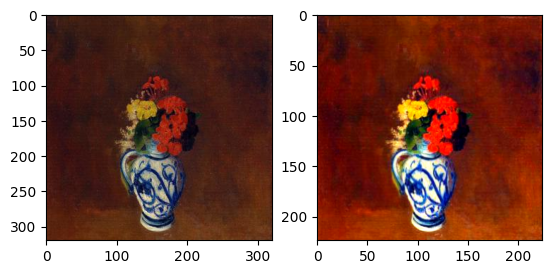

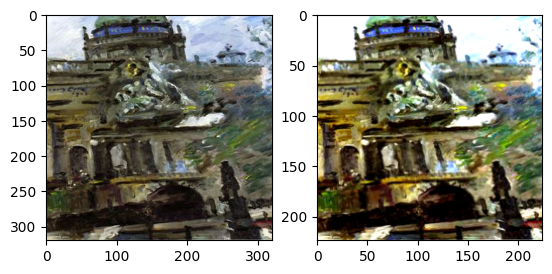

<PIL.Image.Image image mode=RGB size=224x224 at 0x792AB9D68070>


In [231]:
img_paths = random.sample(train_list,4)


print(img_paths)
#print(type(img_transformed))
#print(len(img_transformed))
#print(img_transformed[0])
for i in img_paths:
    img = Image.open(basepath+'/dataset' + config.dataset +trainfolder + i).convert('RGB')
    img_transformed = demo_transforms(img)
    if (config.transforms =="v3"):
       a = additional_transforms(i)
       fig, axs = plt.subplots(1, 2)
       axs[0].imshow(a)
       axs[1].imshow(i)
       plt.show()
    else:
       fig, axs = plt.subplots(1, 2)
       axs[0].imshow(img)
       axs[1].imshow(img_transformed)
       plt.show()
print(img_transformed)


In [232]:
class PaintingDataset(Dataset):
    def __init__(self, file_list, transform=None,train=True,use_gpu=torch.cuda.is_available()): #df(1st)
        self.file_list = file_list
        self.transform = transform
        self.filelength = len(file_list)
        #self.df = df
        self.train = train
        self.use_gpu = use_gpu
        if(train):
            self.folderpath = basepath +'/dataset' + config.dataset +trainfolder
        else:
            self.folderpath = basepath +'/dataset'+config.dataset+testfolder


    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(self.folderpath + img_path).convert('RGB')
        img_transformed = self.transform(img)
        if (config.transforms == "v3"):
          crops = []
          for i in img_transformed:
            if self.train:
              crops.append(additional_transforms(i))
            else:
              crops.append(additional_transforms_t(i))
            img_transformed = torch.stack(crops)

        label = img_path.split("_")[0]
        if(label == 'i'):
            label = F.one_hot(torch.tensor(0),num_classes=4)
        elif(label == 'p'):
            label = F.one_hot(torch.tensor(1),num_classes=4)
        elif(label == 'e'):
            label = F.one_hot(torch.tensor(2),num_classes=4)
        elif(label == 'r'):
            label = F.one_hot(torch.tensor(3),num_classes=4)
        label = torch.tensor(label,dtype=float)
        if self.use_gpu:
            img_transformed = img_transformed.cuda()
            label = label.cuda()
        return img_transformed, label


In [233]:
test_dataset = PaintingDataset(test_list,transform=test_transforms,train=False) #df
val_dataset = PaintingDataset(val_list,transform=test_transforms,train=True) #df
train_dataset = PaintingDataset(train_list,transform=train_transforms,train=True) #df=df_train

In [234]:
a,b = test_dataset[0]
print(b)
# print(a.shape)
# print(torch.mean(a,dim=(1,2)))
# print(torch.std(a,dim=(1,2)))
# normalize_transform = v2.Normalize(mean=(1, 1, 1), std=(1, 1, 1))
# a = normalize_transform(a)
# print(torch.mean(a,dim=(1,2)))
# print(torch.std(a,dim=(1,2)))


/tmp/ipykernel_34/563325967.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label,dtype=float)


tensor([0., 0., 1., 0.], device='cuda:0', dtype=torch.float64)


In [235]:
batch_size = config.batch_size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [236]:
dataiter = iter(test_loader)
a,b = next(dataiter)
print(a.shape)

/tmp/ipykernel_34/563325967.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label,dtype=float)


torch.Size([32, 3, 224, 224])


In [237]:
class CNN(nn.Module): ## Probably something wrong with this one
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        neurons = int(config.imagedim[0]/8 * config.imagedim[1]/8 * 3)
        self.fc1 = nn.Linear(neurons, neurons)
        self.dropout = nn.Dropout(config.dropout)
        self.fc2 = nn.Linear(neurons,neurons)
        self.fc3 = nn.Linear(neurons, 4)

    def forward(self, x):
        #initial dim 3*x*x
        for i in range(3):
            for j in range(5):
                x=F.relu(self.conv(x))
            x=self.pool(x)
        #dim after 3*x/8*x/8
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x))
        return x

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.pool1 = nn.MaxPool2d(7, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 18, 5)
        self.fc1 = nn.Linear(11250, 11250)
        self.dropout = nn.Dropout(config.dropout)
        self.fc2 = nn.Linear(11250, 512)
        self.fc3 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x))
        return x

class DeepShallow(nn.Module):
    def __init__(self):
        super().__init__()
        self.myresnet = models.resnet18(pretrained=True)
        for i, (name, param) in enumerate(self.myresnet.named_parameters()):
            if "layer4" not in name and "layer3" not in name:
                # Freeze the layers by setting requires_grad to False
                param.requires_grad = False
        self.myresnet.fc = nn.Sequential(
            nn.Linear(self.myresnet.fc.in_features, 4),
            nn.Softmax(dim=1)
        )
        
        self.fc1 = nn.Linear(20, 16)
        self.fc2 = nn.Linear(16,4)


    def forward(self, x):
      #print(x.shape)
      curbsize = x.shape[0]
      y = []
      for i in range(5):
        #print(x[:,i,:,:,:].shape)
        y.append(self.myresnet(x[:,i,:,:,:]))

      x= torch.stack(y,dim=1)
      x = x.view(curbsize, -1)
      x = self.fc1(x)
      x = self.fc2(x)
      x = F.softmax(x)
      return x

      #softmax on the last layer


def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.zero_()
        
def _weights_init1(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.zero_()

In [238]:
# not tried yet
def my_accuracy(predictions, labels,multiple=False):
    if(multiple):
        predictions1 = torch.argmax(predictions,dim=1)
        labels = torch.argmax(labels, dim=1) # If we have one-hot encoded vector for the labels
    else:
        predictions1 = torch.abs(torch.round(predictions))
    #print(labels)
    correct = (predictions1 == labels)
    #print(correct)
    acc = sum(correct) / len(predictions1)
    return acc.item()

In [239]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

True
cuda


In [240]:
if config.model_name == "CNN1":
  cnn = CNN()
  cnn.apply(_weights_init)
elif config.model_name == "CNN2":
  cnn = CNN2()
  cnn.apply(_weights_init)
elif config.model_name == "resnet":
  cnn = models.resnet50(pretrained=True)
elif config.model_name == "inception":
  cnn = models.inception_v3(pretrained=True)
elif config.model_name == "deepshallow":
  cnn = DeepShallow()
  cnn.apply(_weights_init1)





cnn.to(device)

cnn.parameters()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<generator object Module.parameters at 0x792ae007f680>

In [241]:
if config.model_name == "resnet" or config.model_name == "inception":
  if config.retrained and config.model_name == "resnet":
    freeze_layers = 4  # Choose the layer from which you want to start freezing
    for i, (name, param) in enumerate(cnn.named_parameters()):
        if not "layer4" in name:
            # Freeze the layers by setting requires_grad to False
            param.requires_grad = False
  else:
    for param in cnn.parameters():
      param.requires_grad = False
  num_classes = 4
  cnn.fc = nn.Sequential(
      nn.Linear(cnn.fc.in_features, num_classes),
      nn.Softmax(dim=1)
  )
  nn.init.xavier_normal_(cnn.fc[0].weight)
  nn.init.constant_(cnn.fc[0].bias, 0)



In [242]:
for name, param in cnn.named_parameters():
    print(f"{name}: {param.requires_grad}")

conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.0.conv3.weight: False
layer1.0.bn3.weight: False
layer1.0.bn3.bias: False
layer1.0.downsample.0.weight: False
layer1.0.downsample.1.weight: False
layer1.0.downsample.1.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer1.1.conv3.weight: False
layer1.1.bn3.weight: False
layer1.1.bn3.bias: False
layer1.2.conv1.weight: False
layer1.2.bn1.weight: False
layer1.2.bn1.bias: False
layer1.2.conv2.weight: False
layer1.2.bn2.weight: False
layer1.2.bn2.bias: False
layer1.2.conv3.weight: False
layer1.2.bn3.weight: False
layer1.2.bn3.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
l

In [243]:
cnn.to(device)
print()

In [244]:
num_epochs = config.epochs # should be more than enough, but can be changed
lr = config.lr # e.q to 0.007, you can change it if needed


if config.weighted_loss:
  criterion = nn.CrossEntropyLoss(weight=loss_weights.to(device))
else:
  criterion = nn.CrossEntropyLoss()

if config.optimizer == "Adam":
  optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
else:
  optimizer = torch.optim.SGD(cnn.parameters(), lr=lr, momentum=config.momentum)


if config.lrscheduler:
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=7e-5, factor=0.5)

wandb.watch(cnn, log_freq=100)

min_val_loss =100


for epoch in range(num_epochs):
    training_loss_epoch = 0
    training_accuracy_epoch = 0
    cnt = 0

    for batch_idx, (train_features_batch, train_labels_batch) in enumerate(train_loader):
        #print("tr batch " + str(cnt) + "/" + str(len(train_loader)))
        print("|",end="")
        optimizer.zero_grad() # please don't forget!
        #?
        #reshaped_train_features_batch = train_features_batch.reshape(len(train_features_batch), -1)
        if config.model_name == "inception":
          y_hat,_ = cnn(train_features_batch)
        else:
          y_hat = cnn(train_features_batch)

        # train_labels_batch = train_labels_batch.reshape(len(train_labels_batch),1)
        # train_labels_batch = train_labels_batch.float()


        training_loss = criterion(y_hat, train_labels_batch)

        training_loss.backward() # remember: You need to tell w.r.t what the gradient is computed
        optimizer.step()

        training_loss_epoch += training_loss.item()

        #print(training_loss)
        #wandb.log({'training_loss_batch': training_loss.item()})

        train_accuracy = my_accuracy(y_hat, train_labels_batch,multiple=True)
        training_accuracy_epoch += train_accuracy

        # print(y_hat)
        # print(train_labels_batch)
        # print(train_accuracy)

        cnt+=1

    print()
    cnt = 0
    validation_loss_epoch = 0
    validation_accuracy_epoch = 0

    for val_features_batch, val_labels_batch in valid_loader:
        val_features_batch, val_labels_batch = val_features_batch.to(device), val_labels_batch.to(device)
        print("|",end="")


        with torch.no_grad():
            #print("val batch " + str(cnt) + "/" + str(len(valid_loader)))

            #reshaped_val_features_batch = val_features_batch.reshape(len(val_features_batch), -1)
            if config.model_name == "inception":
              y_hat_val,_ = cnn(val_features_batch)
            else:
              y_hat_val = cnn(val_features_batch)

            # val_labels_batch = val_labels_batch.reshape(len(val_labels_batch),1)
            # val_labels_batch = val_labels_batch.float()

            validation_loss = criterion(y_hat_val, val_labels_batch)
            validation_loss_epoch += validation_loss.item()

            val_accuracy = my_accuracy(y_hat_val, val_labels_batch,multiple=True)
            validation_accuracy_epoch += val_accuracy

        cnt += 1

    if validation_loss_epoch/len(valid_loader) < min_val_loss:
        min_val_loss = validation_loss_epoch/len(valid_loader)
    
    print()
    print({'training_loss_epoch': training_loss_epoch/len(train_loader), 'validation_loss_epoch': validation_loss_epoch/len(valid_loader)})
    print({'training_accuracy_epoch': training_accuracy_epoch/len(train_loader), 'validation_accuracy_epoch': validation_accuracy_epoch/len(valid_loader)})
    wandb.log({'training_loss_epoch': training_loss_epoch/len(train_loader), 'validation_loss_epoch': validation_loss_epoch/len(valid_loader),
               'training_accuracy_epoch': training_accuracy_epoch/len(train_loader), 'validation_accuracy_epoch': validation_accuracy_epoch/len(valid_loader)})

    #Some early stopping
    if validation_loss_epoch/len(valid_loader) - min_val_loss > 0.08:
       print("stopping early!")
       break
    if training_accuracy_epoch/len(train_loader) - validation_accuracy_epoch/len(valid_loader) > 0.07:
       print("stopping early!")
       break



/tmp/ipykernel_34/563325967.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label,dtype=float)


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
{'training_loss_epoch': 1.2281901147697107, 'validation_loss_epoch': 1.1482875682887588}
{'training_accuracy_epoch': 0.5218881856540084, 'validation_accuracy_epoch': 0.5896008405364862}
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [245]:
save_model=False

if save_model:

  torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': training_loss_epoch/len(train_loader),
        'val_loss': validation_loss_epoch/len(valid_loader)
        }, basepath + '/models/' + config.model_name + wandb.run.name)


ideas for the future: weighted loss, lr scheduler, momentum + sgd, retraining more layers

/tmp/ipykernel_34/563325967.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label,dtype=float)


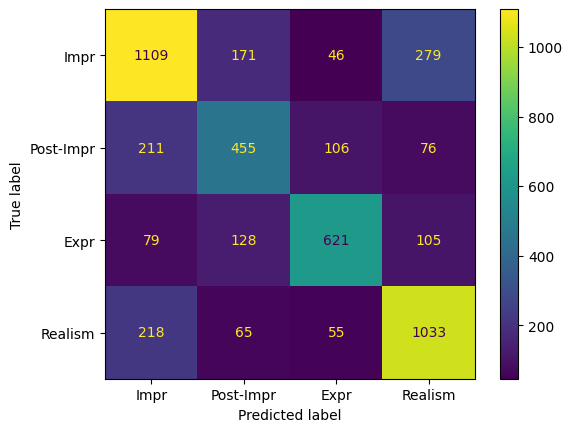

In [246]:
with torch.no_grad():
    cnn.eval()
    test_pred = torch.LongTensor()
    test_labels = torch.LongTensor()
    for i, (data,label) in enumerate(test_loader):
      label = label.cpu()
      output = cnn(data.to(device))
      predicted = output.cpu()
      test_pred = torch.cat((test_pred, predicted), dim=0)
      test_labels = torch.cat((test_labels, label), dim=0)


test_labels_am = torch.argmax(test_labels,dim=1)
test_pred_am= torch.argmax(test_pred,dim=1)
confusion_matrix = metrics.confusion_matrix(test_labels_am, test_pred_am)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Impr", "Post-Impr","Expr","Realism"])

cm_display.plot()
plt.show()

In [247]:
cm = wandb.plot.confusion_matrix(
    y_true=test_labels_am.tolist(), preds=test_pred_am.tolist(), class_names=["Impr", "Post-Impr","Expr","Realism"]
)

wandb.log({"conf_mat": cm,"pr": wandb.plot.pr_curve(test_labels_am, test_pred,labels=["Impr", "Post-Impr","Expr","Realism"])})


In [248]:
test_accuracy = metrics.accuracy_score(test_pred_am, test_labels_am)
print("test_accuracy")
print(test_accuracy)
top2accuracy = metrics.top_k_accuracy_score(test_labels_am,test_pred)
print("top2_accuracy")
print(top2accuracy)
recall = metrics.recall_score(test_labels_am, test_pred_am,average='micro')
print("recall")
print(recall)
precision = metrics.precision_score(test_labels_am, test_pred_am,average='micro')
print("precision")
print(precision)

wandb.log({"test_accuracy": test_accuracy,"top2_accuracy": top2accuracy})


test_accuracy
0.6764767710742065
top2_accuracy
0.8826991801555603
recall
0.6764767710742065
precision
0.6764767710742065


In [249]:
wandb.finish()

wandb: WARNING No program path found when generating artifact job source for a non-colab notebook run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_accuracy,▁
top2_accuracy,▁
training_accuracy_epoch,▁▃▄▄▅▅▆▆▆▇▇▇██
training_loss_epoch,█▆▅▄▄▄▃▃▂▂▂▂▁▁
validation_accuracy_epoch,▁▃▃▄▅█▇▇█▆▇▇▇▇
validation_loss_epoch,█▇▆▅▅▂▄▃▁▂▂▃▃▄
test_accuracy,0.67648
top2_accuracy,0.8827
training_accuracy_epoch,0.72811
training_loss_epoch,1.01169
validation_accuracy_epoch,0.6563


In [251]:
save_model=True

if save_model:
  basepath='./'

  torch.save({
        'epoch': epoch,
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': training_loss_epoch/len(train_loader),
        'val_loss': validation_loss_epoch/len(valid_loader)
        }, config.model_name + "v6_Adam_weightedloss_transformsv1final")
